In [1]:
import torch
import numpy as np
import scipy.integrate
from numpy import sin, cos
import matplotlib.pyplot as plt
import random
solver = scipy.integrate.solve_ivp

seed = 36
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.determinstic = True


In [2]:
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
import pandas as pd

BATCH_size = 1000

dftarget = pd.read_csv("./data/target.csv", header=None, dtype=np.float32)
dfinput = pd.read_csv("./data/input.csv", header=None, dtype=np.float32)

X_train, X_test, Y_train, Y_test = train_test_split(dfinput.values, dftarget.values, test_size=0.2)

# train data
data_train = data_utils.TensorDataset(torch.tensor(X_train), torch.tensor(Y_train))
train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_size, shuffle=True)

# test data
data_test = data_utils.TensorDataset(torch.tensor(X_test), torch.tensor(Y_test))
test_loader = torch.utils.data.DataLoader(data_test, batch_size=BATCH_size, shuffle=True)

In [3]:
import torch.nn as nn
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#!nvidia-smi

In [4]:
class MLP(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(MLP, self).__init__()
    self.l1 = nn.Linear(input_size, hidden_size)
    self.l2 = nn.Linear(hidden_size, hidden_size)
    self.l3 = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    x = self.l1(x)
    x = torch.tanh(x)
    x = self.l2(x)
    x = torch.tanh(x)
    x = self.l3(x)
    return x

  def fvec(self, t, x):
    return self.forward(x)

In [5]:
import time
input_size = 4
output_size = 4
hidden_size = 200

num_trials = 10
stats = {'train_loss': [], 'eval_loss': [], 'computation_time': []}

for trial in range(num_trials):
  mlp_net = MLP(input_size, hidden_size, output_size).to(device)

  num_epochs = 2000
  criterion = nn.MSELoss()
  optimizer = optim.Adam(params=mlp_net.parameters(), lr=0.001)

  history_loss = []
  history_eval = []
  history_acc = []
  startt = time.time()
  for epoch in range(num_epochs):
    mlp_net.train()
    total_loss = 0.0
    eval_loss = 0.0
    for i,(data,target) in enumerate(train_loader):
      optimizer.zero_grad()
      output = mlp_net(data.to(device))
      target = target.to(device)

      loss = criterion(output,target)
      loss.backward()
      optimizer.step()

      total_loss = total_loss+loss.cpu().item()
    total_loss = total_loss/i

    num_correct = 0
    num_data = 0
    mlp_net.eval()
    eval_loss = 0.0
    for i,(data,target) in enumerate(test_loader):
      output = mlp_net(data.to(device))
      target = target.to(device)

      eval_loss = eval_loss+criterion(output,target).cpu().item()
    eval_loss = eval_loss/i

    history_loss.append(total_loss)
    history_eval.append(eval_loss)
  print("{}/{} training loss:{},evaluation loss:{}".format(epoch+1,num_epochs,total_loss,eval_loss))
  path = "./model/node_dp_2t_{}".format(trial)
  torch.save(mlp_net.state_dict(), path)
  stats['train_loss'].append(total_loss)
  stats['eval_loss'].append(eval_loss)
  stats['computation_time'].append(time.time() - startt)



print("train_loss:{}, std: {}".format(np.mean(stats['train_loss']), np.std(stats['train_loss'])))
print("test_loss:{}, std: {}".format(np.mean(stats['eval_loss']), np.std(stats['eval_loss'])))
print("computation_time:{}, std: {}".format(np.mean(stats['computation_time']), np.std(stats['computation_time'])))

2000/2000 training loss:0.00015587025499022594,evaluation loss:0.00022053980743900561
2000/2000 training loss:0.00015187158749300442,evaluation loss:0.0002251262079740767
2000/2000 training loss:0.0001774641336307937,evaluation loss:0.0002439485675168749
2000/2000 training loss:0.00018908168672827078,evaluation loss:0.0002668427987373434
2000/2000 training loss:0.0001531707799219916,evaluation loss:0.00022038972010471835
2000/2000 training loss:0.00014602029049965267,evaluation loss:0.00022011778613280816
2000/2000 training loss:0.00014345553701684176,evaluation loss:0.00019140879409790685
2000/2000 training loss:0.00012702489759660994,evaluation loss:0.0001845303225145938
2000/2000 training loss:0.00013921575448893117,evaluation loss:0.00020119669501675674
2000/2000 training loss:0.00012809355519825458,evaluation loss:0.00018179872299347504
train_loss:0.00015112684775645766, std: 1.8707461833847666e-05
test_loss:0.00021558994225275596, std: 2.5472510007833606e-05
computation_time:1446

In [7]:
A = pd.read_csv("./data/A.csv", header=None, dtype=np.float32)
B = pd.read_csv("./data/B.csv", header=None, dtype=np.float32)
#A = np.mat(A) # `np.mat` was removed in the NumPy 2.0 release. Use `np.asmatrix` instead.
#B = np.mat(B)(A)
A = np.asmatrix(A)
B = np.asmatrix(B)

[0.73424656 0.6566721  0.42773057 0.74193278]


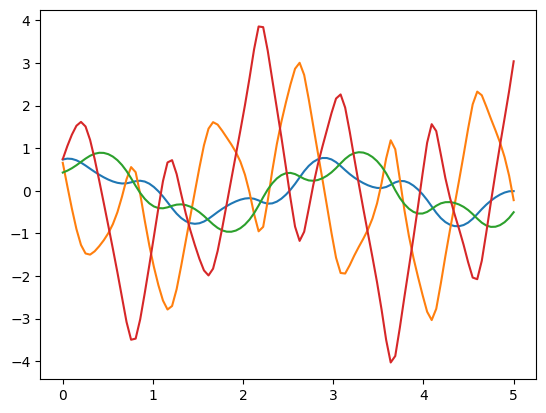

energy_error0:9.137264966096275


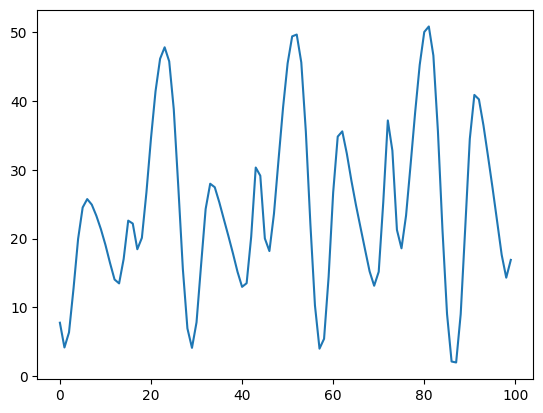

[0.3391952  0.01912268 0.42160305 0.99741402]


/tmp/ipykernel_79091/4265574.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(A, dtype=torch.float32)
/tmp/ipykernel_79091/4265574.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  B = torch.tensor(B, dtype=torch.float32)


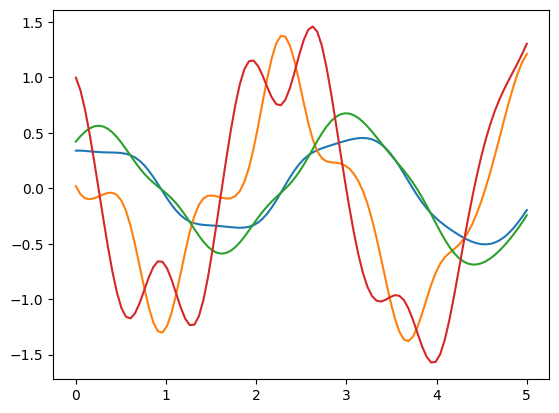

energy_error1:13.431099685313953


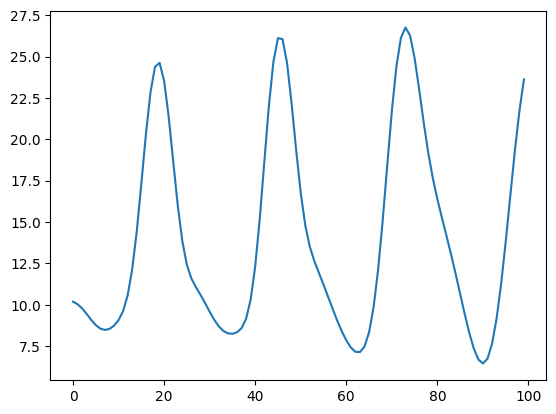

[0.03656911 0.92395591 0.23967218 0.95224603]


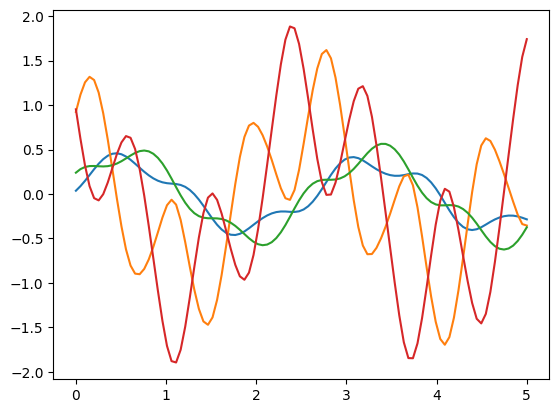

energy_error2:-7.0736549846607275


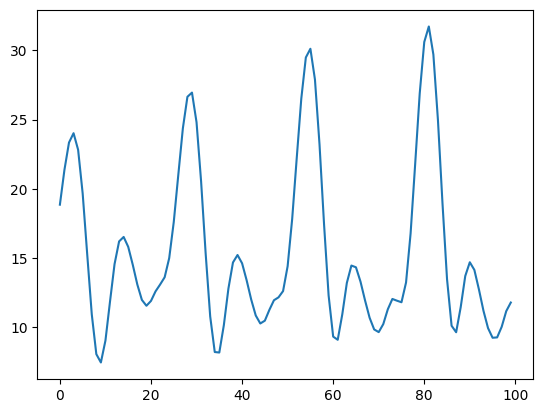

[0.26485681 0.29738391 0.98458253 0.46614086]


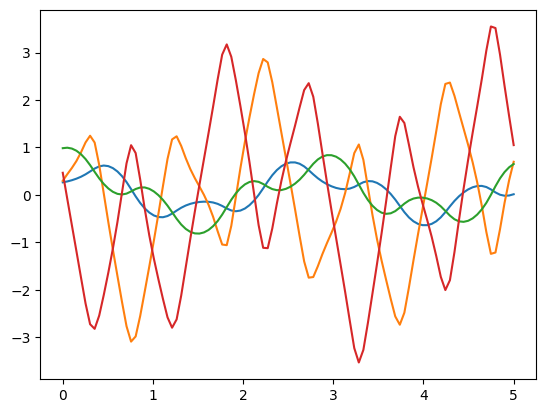

energy_error3:4.950229335687823


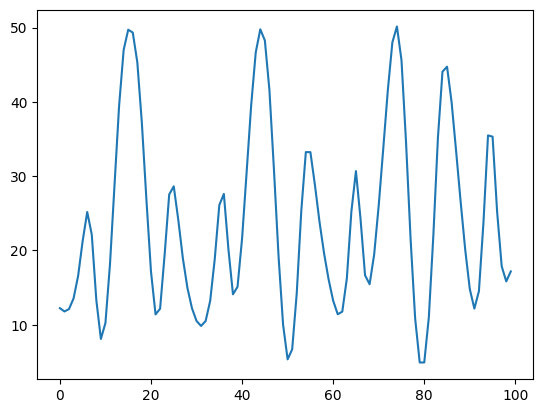

[0.95620719 0.08908681 0.10023305 0.73110729]


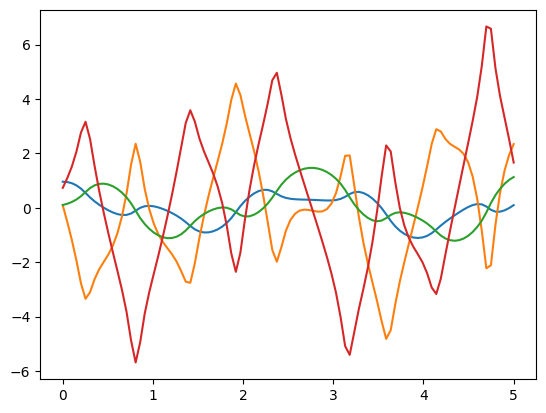

energy_error4:47.14311947923365


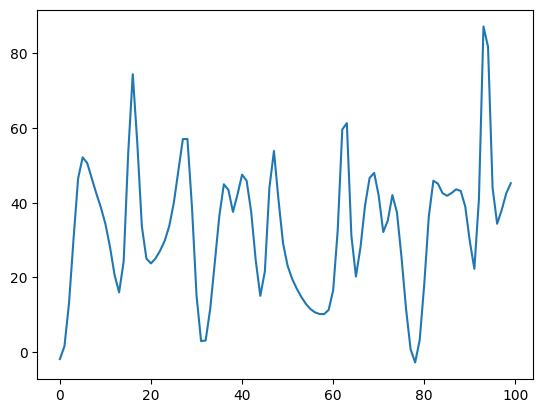

[0.56925707 0.38088485 0.51448741 0.89776162]


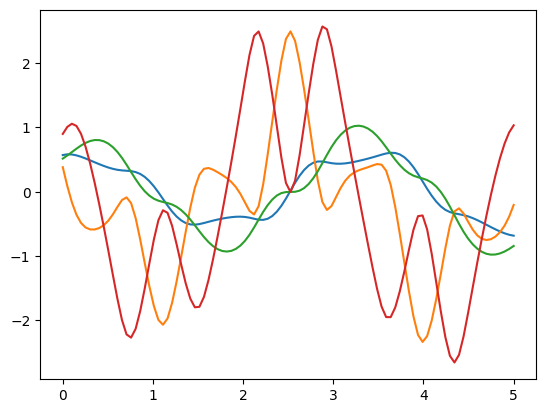

energy_error5:-4.491173355741537


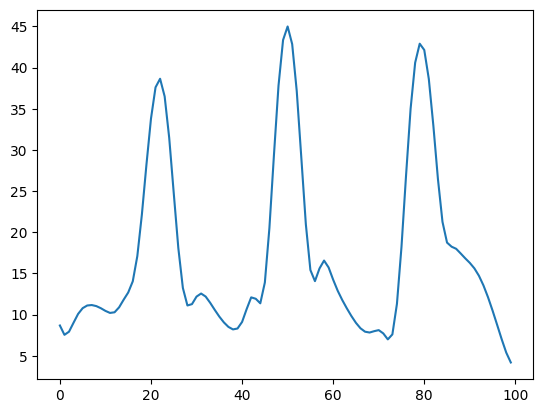

[0.57982002 0.89532277 0.52784278 0.28848429]


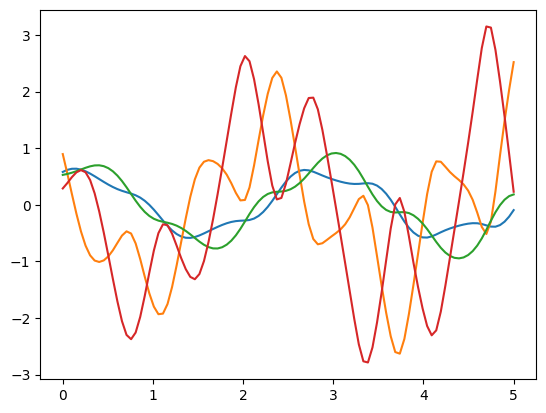

energy_error6:32.09393188403469


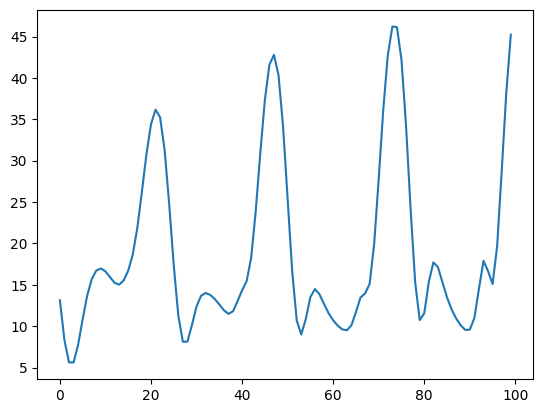

[0.40574935 0.55496527 0.98283737 0.54627115]


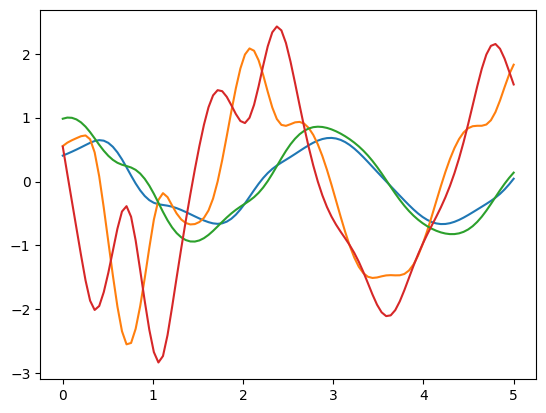

energy_error7:23.45044714423156


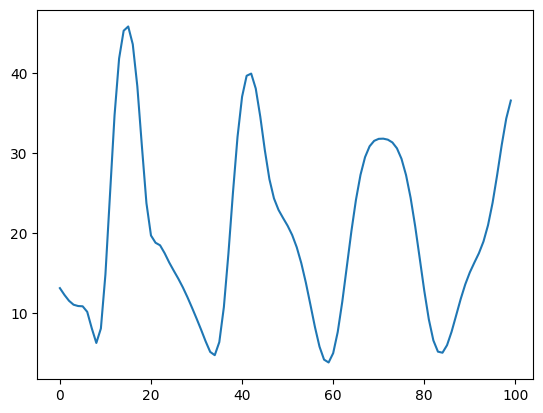

[0.63119862 0.3641424  0.44832169 0.35867564]


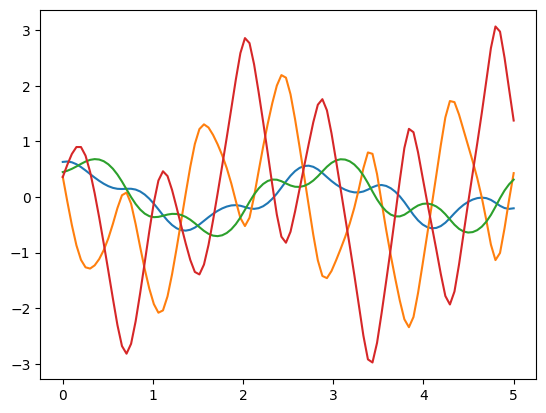

energy_error8:7.54482367388518


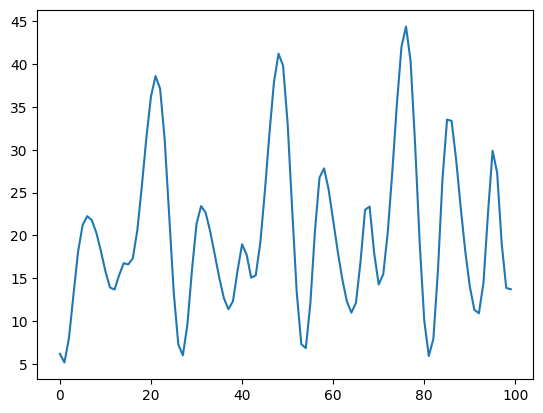

[0.17174863 0.36357341 0.30217936 0.96340619]


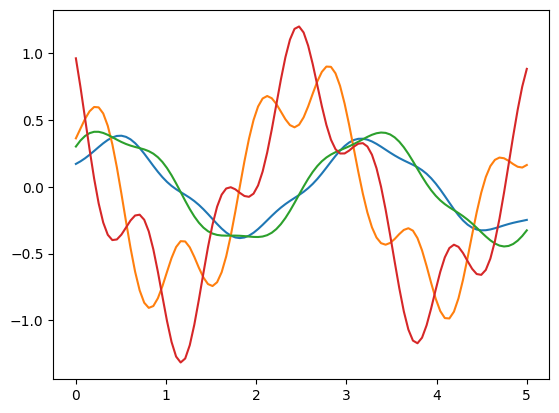

energy_error9:-2.709448803681571


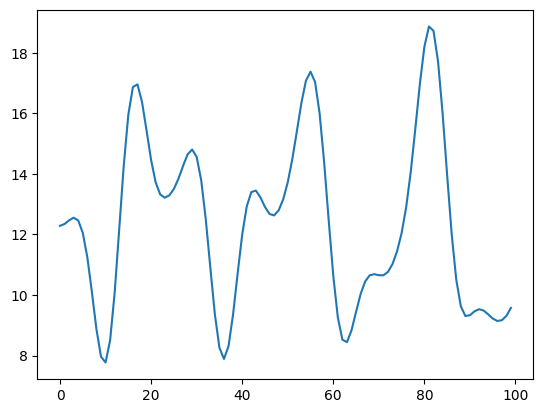

eq_error:[np.float64(9.137264966096275), np.float64(13.431099685313953), np.float64(-7.0736549846607275), np.float64(4.950229335687823), np.float64(47.14311947923365), np.float64(-4.491173355741537), np.float64(32.09393188403469), np.float64(23.45044714423156), np.float64(7.54482367388518), np.float64(-2.709448803681571)]
eq_error:15.202519331256696, std: 16.433597114250727


In [8]:
# simulation
# parameters
g = 9.8
m1 = 1.0
m2 = 2.0
l1 = 1.0
l2 = 1.0
m = m1+m2
eq_error = []

for trial in range(num_trials):
  mlp_net.load_state_dict(torch.load("./model/node_dp_2t_{}".format(trial), map_location="cpu"))
  mlp_net.eval()
  teval = torch.linspace(0.0,5.0,100)
  x0 = np.random.rand(4)
  #x0 = (0.01825532, 0.52412613, 0.33688556, 0.20706259)
  print(x0)
  dt = teval[1]-teval[0]
  teval = teval.detach().cpu().numpy()
  A = torch.tensor(A, dtype=torch.float32)
  B = torch.tensor(B, dtype=torch.float32)
  mlp_net.eval()
  mlp_net.cpu()
  def fvec_np(x,t):
      tx = torch.tensor(x, dtype=torch.float).unsqueeze(0)
      x = torch.matmul(tx, torch.inverse(B))
      output = mlp_net.forward(x).squeeze(0)
      output = torch.matmul(A, output)
      output = output.squeeze(0)
      return output.detach().cpu().numpy()
  res = scipy.integrate.odeint(fvec_np,x0,teval)
  plt.plot(teval,res[:,0])
  plt.plot(teval,res[:,1])
  plt.plot(teval,res[:,2])
  plt.plot(teval,res[:,3])
  plt.show()

  energy = (1/2)*(m1+m2)*np.square(l1)*np.square(res[:,2])+(1/2)*m2*np.square(l2)*np.square(res[:,3])+m2*l1*l2*res[:,2]*res[:,3]*np.cos(res[:,0]-res[:,1])+g*(m1+m2)*l1*np.cos(res[:,0])-g*m2*l2*np.cos(res[:,1])
  energy_error=energy[99]-energy[0]
  print("energy_error{}:{}".format(trial,energy_error))
  plt.plot(energy)
  plt.show()

  eq_error.append(energy_error)

print("eq_error:{}".format(eq_error))
print("eq_error:{}, std: {}".format(np.mean(np.abs(eq_error)), np.std(eq_error)))

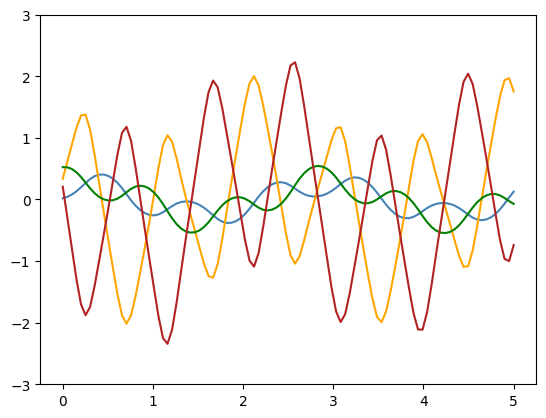

In [9]:
# Ground truth
# parameters
g = 9.8
m1 = 1.0
m2 = 2.0
l1 = 1.0
l2 = 1.0
m = m1+m2
# equations of motion
def func(t, state):
  cosv = np.cos(state[0]-state[1])
  sinv = np.sin(state[0]-state[1])
  dvdt = np.zeros_like(state)
  dvdt[0] = state[2]
  dvdt[1] = state[3]
  dvdt[2] = (g*(np.sin(state[1])*cosv - m/m2*np.sin(state[0])) - (l1*state[2]*state[2]*cosv + l2* state[3]*state[3])*sinv) / (l1*(m/m2-cosv*cosv))
  dvdt[3] = (g*m/m2*(np.sin(state[0])*cosv - np.sin(state[1])) + sinv * (l1*state[2]*state[2]*m/m2 + l2* state[3]*state[3]*cosv)) / (l2*(m/m2-cosv*cosv))
  return dvdt

#　the time grid
M = 100
tend = 5.0
t_eval = np.linspace(0,tend,M)
dt = t_eval[1]-t_eval[0]

state = []
for i in range(1):
  s = (0.01825532, 0.52412613, 0.33688556, 0.20706259 )
  state.append(s)
p1 = []
v1 = []
p2 = []
v2 = []
flag = False
for i in range(1):
  sol = solver(func, [0, tend], state[i], t_eval=t_eval)
  tval = sol['t']
  q1 = sol['y'][0]
  q2 = sol['y'][1]
  v1 = sol['y'][2]
  v2 = sol['y'][3]
  ax=plt.subplot()
  ax.set_ylim([-3,3])
  ax.plot(tval, q1, 'steelblue')
  ax.plot(tval, v1, 'orange')
  ax.plot(tval, q2, 'g')
  ax.plot(tval, v2, 'firebrick')
  plt.show()

